In [51]:
# Imports
import copy
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from ptflops import get_model_complexity_info
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from models import LabelledJetDataset, VAE, Classifier


In [52]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets (consistent with previous notebooks)
labelled_dataset = LabelledJetDataset('../Dataset_Specific_labelled.h5')
train_size = int(0.8 * len(labelled_dataset))
test_size = len(labelled_dataset) - train_size
train_labelled, test_labelled = random_split(labelled_dataset, [train_size, test_size])
train_loader = DataLoader(train_labelled, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_labelled, batch_size=64, shuffle=False, num_workers=4)

# Load pre-trained models (consistent with previous notebooks)
vae = VAE(latent_dim=128).to(device)
classifier = Classifier(vae, latent_dim=128).to(device)

def load_model(model, path):
    state_dict = torch.load(path, map_location=device)
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)

try:
    load_model(vae, './res/best/best_vae.pth')
    load_model(classifier, './res/best/best_classifier.pth')
    print("Models loaded successfully")
except FileNotFoundError as e:
    print(f"Error: Model file not found - {e}")
except RuntimeError as e:
    print(f"Error loading state dict: {e}")

# ---------------------------
# Helper Function: Compute AUC
# ---------------------------
def compute_auc(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Apply sigmoid since outputs are logits
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(probs.ravel())
            all_labels.extend(labels.cpu().numpy())
    auc_value = roc_auc_score(all_labels, all_preds)
    return auc_value


Using device: cuda
Models loaded successfully


In [53]:
# ---------------------------
# Pruning Functions
# ---------------------------
def prune_model(model, pruning_ratio):
    """
    Unstructured pruning: prune each Conv2d and Linear layer using L1 norm.
    """
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=pruning_ratio)
            prune.remove(module, 'weight')

def iterative_prune_and_finetune(model, train_loader, device, total_pruning_ratio, step_size=0.1, fine_tune_epochs=5):
    """
    Iteratively prune and fine-tune the model using training data.
    """
    pruned_model = copy.deepcopy(model)
    current_pruning_ratio = 0.0
    optimizer = optim.Adam(pruned_model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()  # binary classification loss

    while current_pruning_ratio < total_pruning_ratio:
        step_pruning_ratio = min(step_size, total_pruning_ratio - current_pruning_ratio)
        # Apply unstructured pruning step
        for name, module in pruned_model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                prune.l1_unstructured(module, name='weight', amount=step_pruning_ratio / (1 - current_pruning_ratio))
                prune.remove(module, 'weight')
        # Fine-tune pruned model
        pruned_model.train()
        for epoch in range(fine_tune_epochs):
            for batch in train_loader:
                images, labels = batch
                # Ensure image shape is as expected
                if images.shape[1:] != torch.Size([8, 128, 128]):
                    continue
                images = images.to(device)
                labels = labels.to(device)
                if labels.dim() == 1:
                    labels = labels.unsqueeze(1)
                optimizer.zero_grad()
                outputs = pruned_model(images)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()
        current_pruning_ratio += step_pruning_ratio
    return pruned_model

def prune_filters(model, pruning_ratio):
    """
    Structured pruning: remove entire filters from Conv2d layers based on L1 norm.
    """
    pruned_model = copy.deepcopy(model)
    for name, module in pruned_model.named_modules():
        if isinstance(module, nn.Conv2d):
            weight = module.weight.data
            num_filters = weight.size(0)
            # Compute L1 norm for each filter
            norm = weight.abs().sum(dim=(1, 2, 3))
            num_prune = int(num_filters * pruning_ratio)
            if num_prune >= num_filters:
                continue
            prune_indices = norm.sort()[1][:num_prune]
            mask = torch.ones(num_filters, device=weight.device)
            mask[prune_indices] = 0
            new_weight = weight * mask.view(-1, 1, 1, 1)
            module.weight.data = new_weight
    return pruned_model

# ---------------------------
# Evaluate Original Classifier
# ---------------------------
original_auc = compute_auc(classifier, test_loader, device)
original_error = 1 - original_auc
original_flops, _ = get_model_complexity_info(classifier, (8, 128, 128), as_strings=False)
print(f'Original AUC: {original_auc:.4f}, Error (1-AUC): {original_error:.4f}, FLOPS: {original_flops:.2e}')

Classifier(
  3.48 M, 100.000% Params, 21.6 MMac, 99.998% MACs, 
  (vae): VAE(
    3.42 M, 98.104% Params, 21.53 MMac, 99.691% MACs, 
    (encoder): Sequential(
      98.64 k, 2.832% Params, 19.37 MMac, 89.673% MACs, 
      (0): Conv2d(1.17 k, 0.034% Params, 4.78 MMac, 22.153% MACs, 8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, 0.001% Params, 131.07 KMac, 0.607% MACs, 16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(0, 0.000% Params, 65.54 KMac, 0.303% MACs, negative_slope=0.2)
      (3): Conv2d(4.64 k, 0.133% Params, 4.75 MMac, 22.001% MACs, 16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.303% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(0, 0.000% Params, 32.77 KMac, 0.152% MACs, negative_slope=0.2)
      (6): Conv2d(18.5 k, 0.531% Params, 4.73 MMac, 21.925% MACs, 32, 64, kernel_size=(3, 3), 

In [54]:
# ---------------------------
# Pruning Evaluation Setup
# ---------------------------
pruning_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sparsity_percent = [r * 100 for r in pruning_ratios]
errors = {'Unstructured': [], 'Iterative': [], 'Structured': []}
flops_list = {'Unstructured': [], 'Iterative': [], 'Structured': []}

total_iterations = len(pruning_ratios) * 3
print(f"\nStarting pruning evaluation with {total_iterations} iterations...")

for i, r in enumerate(pruning_ratios):
    start_time = time.time()

    # ----- Unstructured Pruning -----
    pruned_classifier = copy.deepcopy(classifier)
    prune_model(pruned_classifier, r)
    auc_unstructured = compute_auc(pruned_classifier, test_loader, device)
    error_unstructured = 1 - auc_unstructured
    # Approximate FLOPS reduction: original FLOPS * (1 - pruning_ratio)
    flops_unstructured = original_flops * (1 - r)
    errors['Unstructured'].append(error_unstructured)
    flops_list['Unstructured'].append(flops_unstructured)

    # ----- Iterative Pruning with Fine-Tuning -----
    pruned_classifier_iter = iterative_prune_and_finetune(classifier, train_loader, device, r)
    auc_iterative = compute_auc(pruned_classifier_iter, test_loader, device)
    error_iterative = 1 - auc_iterative
    flops_iterative = original_flops * (1 - r)
    errors['Iterative'].append(error_iterative)
    flops_list['Iterative'].append(flops_iterative)

    # ----- Structured Pruning -----
    pruned_classifier_struct = prune_filters(classifier, r)
    auc_structured = compute_auc(pruned_classifier_struct, test_loader, device)
    error_structured = 1 - auc_structured
    flops_structured = original_flops * (1 - r)
    errors['Structured'].append(error_structured)
    flops_list['Structured'].append(flops_structured)

    end_time = time.time()
    iteration_time = end_time - start_time
    print(f"\nPruning Ratio {r:.1f}:")
    print(f"  Unstructured: AUC {auc_unstructured:.4f}, Error {error_unstructured:.4f}, FLOPS approx. {flops_unstructured:.2e}")
    print(f"  Iterative:    AUC {auc_iterative:.4f}, Error {error_iterative:.4f}, FLOPS approx. {flops_iterative:.2e}")
    print(f"  Structured:   AUC {auc_structured:.4f}, Error {error_structured:.4f}, FLOPS approx. {flops_structured:.2e}")
    print(f"  Iteration Time: {iteration_time:.2f} seconds")



Starting pruning evaluation with 30 iterations...

Pruning Ratio 0.0:
  Unstructured: AUC 0.8925, Error 0.1075, FLOPS approx. 2.16e+07
  Iterative:    AUC 0.8925, Error 0.1075, FLOPS approx. 2.16e+07
  Structured:   AUC 0.8925, Error 0.1075, FLOPS approx. 2.16e+07
  Iteration Time: 3.11 seconds

Pruning Ratio 0.1:
  Unstructured: AUC 0.8922, Error 0.1078, FLOPS approx. 1.94e+07
  Iterative:    AUC 0.9231, Error 0.0769, FLOPS approx. 1.94e+07
  Structured:   AUC 0.8900, Error 0.1100, FLOPS approx. 1.94e+07
  Iteration Time: 19.88 seconds

Pruning Ratio 0.2:
  Unstructured: AUC 0.8924, Error 0.1076, FLOPS approx. 1.73e+07
  Iterative:    AUC 0.9351, Error 0.0649, FLOPS approx. 1.73e+07
  Structured:   AUC 0.8801, Error 0.1199, FLOPS approx. 1.73e+07
  Iteration Time: 36.81 seconds

Pruning Ratio 0.3:
  Unstructured: AUC 0.8918, Error 0.1082, FLOPS approx. 1.51e+07
  Iterative:    AUC 0.9302, Error 0.0698, FLOPS approx. 1.51e+07
  Structured:   AUC 0.8620, Error 0.1380, FLOPS approx. 1.5

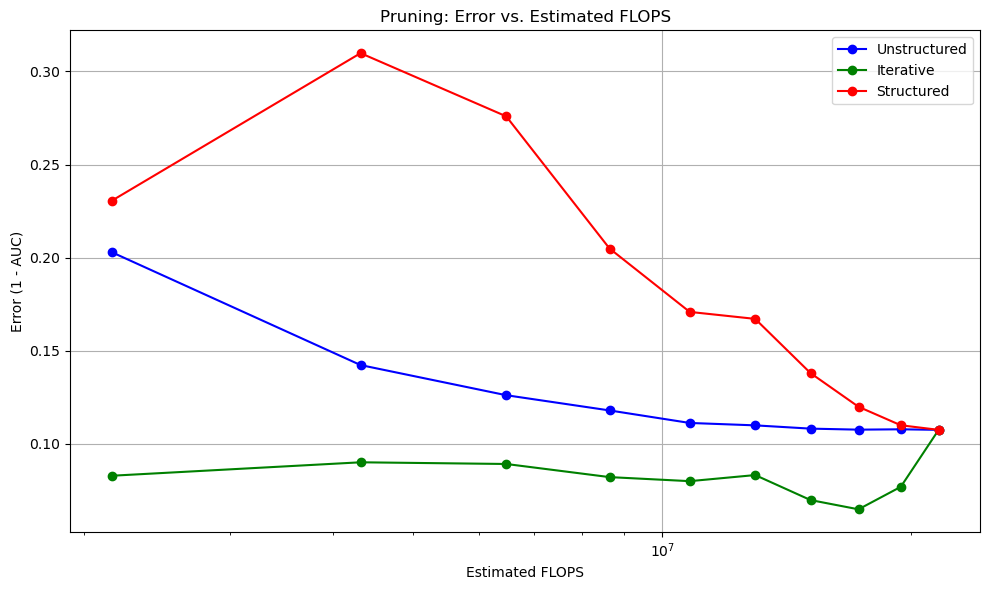

In [55]:
# ---------------------------
# Plot Error vs. FLOPS for Pruned Models
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(flops_list['Unstructured'], errors['Unstructured'], 'b-o', label='Unstructured')
plt.plot(flops_list['Iterative'], errors['Iterative'], 'g-o', label='Iterative')
plt.plot(flops_list['Structured'], errors['Structured'], 'r-o', label='Structured')
plt.xlabel('Estimated FLOPS')
plt.ylabel('Error (1 - AUC)')
plt.title('Pruning: Error vs. Estimated FLOPS')
plt.grid(True)
plt.xscale('log')  # using log scale
plt.legend()
plt.tight_layout()
plt.show()